In [1]:
import os,sys

import ufl
import dolfin as dl

sys.path.append(os.environ.get('HIPPYLIB_PATH'))
import hippylib as hp
sys.path.append(os.environ.get('HIPPYFLOW_PATH'))
import hippyflow as hf

import torch

import gempy as gp
import gempy_engine
import gempy_viewer as gpv
from gempy_engine.core.backend_tensor import BackendTensor
from gempy_probability.plot_posterior import default_red, default_blue, PlotPosterior

from helpers import *

Setting Backend To: AvailableBackends.numpy


## Set up the gempy model

In [2]:
geo_model_test = create_initial_gempy_model_3_layer(refinement=7, save=True)

Setting Backend To: AvailableBackends.numpy


/Users/tomoleary/miniconda3_x86/envs/gempy/lib/python3.11/site-packages/gempy/core/data/structural_frame.py:206: UserWarning: The basement color was already used in the structural elements.Changing the basement color to #ffbe00.
  warnings.warn(f"The basement color was already used in the structural elements."


Chunking done: 12 chunks
Chunking done: 12 chunks


## Set up the function spaces

In [3]:
nx = 10; ny = 10;
mesh = dl.RectangleMesh(dl.Point(0.0, 0.0), dl.Point(1.0, 1.0), nx, ny)
Vh_STATE = dl.FunctionSpace(mesh, "CG", 2)
Vh_PARAMETER = dl.FunctionSpace(mesh, "CG", 1)
Vh = [Vh_STATE, Vh_PARAMETER, Vh_STATE]


## Evaluate the gempy m on a grid

In [4]:
loaded_array = mesh.coordinates()
#print(loaded_array)
if loaded_array.shape[1]==2:
    xyz_coord = np.insert(loaded_array, 1, 0, axis=1)
elif loaded_array.shape[1]==3:
    xyz_coord = loaded_array
gp.set_custom_grid(geo_model_test.grid, xyz_coord=xyz_coord)
geo_model_test.interpolation_options.mesh_extraction = False

Active grids: GridTypes.DENSE|CUSTOM|NONE


In [5]:
###############################################################################
# Solve the gempy to compute the model
###############################################################################
sol = gp.compute_model(geo_model_test)
m_values = geo_model_test.solutions.octrees_output[0].last_output_center.custom_grid_values

Setting Backend To: AvailableBackends.numpy
Chunking done: 12 chunks
Chunking done: 12 chunks


## Plotting m in its pixel basis

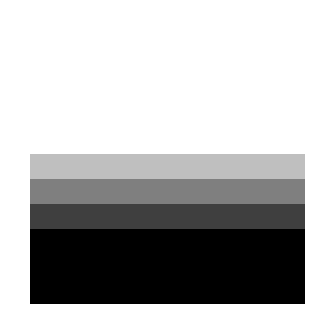

In [6]:
plt.imshow(m_values.reshape((nx+1,ny+1)),origin = 'lower',cmap='binary')
plt.axis("off")
fig = plt.gcf()
fig.set_size_inches(1, 1)
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)


## As a function

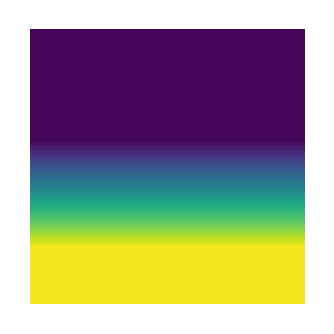

In [7]:
d2v = dl.dof_to_vertex_map(Vh[hp.PARAMETER])
v2d = dl.vertex_to_dof_map(Vh[hp.PARAMETER])

m = dl.Function(Vh[hp.PARAMETER])
m.vector().set_local(m_values[d2v])
plt.axis("off")
dl.plot(m)
fig = plt.gcf()
fig.set_size_inches(1, 1)

## Poisson PDE

In [8]:
def u_boundary(x, on_boundary):
    return on_boundary and ( x[1] < dl.DOLFIN_EPS or x[1] > 1.0 - dl.DOLFIN_EPS)

u_bdr = dl.Expression("x[1]", degree=1)
u_bdr0 = dl.Constant(0.0)
bc = dl.DirichletBC(Vh[hp.STATE], u_bdr, u_boundary)
bc0 = dl.DirichletBC(Vh[hp.STATE], u_bdr0, u_boundary)

f = dl.Constant(0.0)

def pde_varf(u,m,p):
    return ufl.exp(m)*ufl.inner(ufl.grad(u), ufl.grad(p))*ufl.dx - f*p*ufl.dx

pde = hp.PDEVariationalProblem(Vh, pde_varf, bc, bc0, is_fwd_linear=True)

## Instance input output observable class

In [9]:
u_trial = dl.TrialFunction(Vh[hp.STATE])
u_test = dl.TestFunction(Vh[hp.STATE])

M_U = dl.assemble(dl.inner(u_trial,u_test)*dl.dx)

I_U = hf.StateSpaceIdentityOperator(M_U)

observable = hf.LinearStateObservable(pde,M_U)

Jm = hf.ObservableJacobian(observable)

## Sensitivities of m wrt coefficients

Suppose $m$ is a function of some finite dimensional coefficients $c \in \mathbb{R}^{d_c}$

Deep, please extract the matrix 

$$ \frac{dm}{dc} \in \mathbb{R}^{d_M\times d_c} $$

Then we can get the Jacobian with respect to $c$ as 

$$ \frac{du}{dc} = \frac{du}{dm}\frac{dm}{dc} = - \left[\frac{\partial R}{\partial u}\right]^{-1}\frac{\partial R}{\partial m} \frac{dm}{dc} $$

In [10]:
dM = m_values.shape[0]
dc = 2
cs = np.random.rand(dc)

In [11]:
cs_torch = torch.tensor(cs)

In [12]:
# geo_model_test.interpolation_input.surface_points.sp_coords

In [13]:
# grad_data , J, U =[], [], []
# for i in range(parameters.shape[0]):
    
#     mu_1 = parameters[i,0].clone().requires_grad_(True)
#     mu_2 = parameters[i,1].clone().requires_grad_(True)
#     list_paramter = [mu_1, mu_2]
    
    
#     interpolation_input = geo_model_test.interpolation_input
    
#     # If 'sp_coords' is a tensor and you want to convert it to float32
    

#     interpolation_input.surface_points.sp_coords = torch.index_put(
#                             interpolation_input.surface_points.sp_coords,
#                             (torch.tensor([1]), torch.tensor([2])),
#                             mu_1)
#     interpolation_input.surface_points.sp_coords = torch.index_put(
#                             interpolation_input.surface_points.sp_coords,
#                             (torch.tensor([4]), torch.tensor([2])),
#                             mu_2)
#     # # Compute the geological model
#     geo_model_test.solutions = gempy_engine.compute_model(
#                 interpolation_input=interpolation_input,
#                 options=geo_model_test.interpolation_options,
#                 data_descriptor=geo_model_test.input_data_descriptor,
#                 geophysics_input=geo_model_test.geophysics_input,
#             )
            
#     # Compute and observe the thickness of the geological layer

#     custom_grid_values = geo_model_test.solutions.octrees_output[0].last_output_center.custom_grid_values
    
#     # Identity = torch.eye(custom_grid_values.shape[0], dtype=dtype)
    
#     grad_K_k =torch.zeros(( parameters.shape[1],custom_grid_values.shape[0]),dtype=dtype)
    
#     for k in range(len(list_paramter)):
#         for j in range(custom_grid_values.shape[0]):
#             y_x = grad(custom_grid_values[j], list_paramter[k],  retain_graph=True)
#             grad_K_k[k,j] = y_x[0]
    
#     grad_data.append(grad_K_k)

In [14]:
# Pretending this random vector is the dm/dc Jacobian.
dmdc = np.random.randn(dM,dc)

In [16]:
# Compute the action of Jm on dm/dc one column at a time:

# First we need to solve and set the linearization point:

u = dl.Function(Vh[hp.STATE])
uadj = dl.Function(Vh[hp.ADJOINT])
x = [u.vector(),m.vector(),uadj.vector()]

# x = [pde.generate_state(),pde.generate_parameter(),None]
# x[hp.PARAMETER].zero()
# x[hp.PARAMETER].axpy(1,m.vector())

pde.solveFwd(x[hp.STATE], x)

Jm.observable.setLinearizationPoint(x)

uhat = dl.Function(Vh[hp.STATE])
mhat = dl.Function(Vh[hp.PARAMETER])

dU = uhat.vector().get_local().shape[0]
Jc = np.zeros((dU,dc))

for i in range(dc):
    mhat.vector().set_local(dmdc[:,i])
    Jm.mult(mhat.vector(),uhat.vector())
    Jc[:,i] = uhat.vector().get_local()


## Plot some output sensitivities

In [ ]:

for i in range(dc):
    uhat.vector().zero()
    print(80*'#')
    print('Mode ',i)
    uhat.vector().set_local(Jc[:,i])
    plt.axis("off")
    dl.plot(m)
    fig = plt.gcf()
    fig.set_size_inches(1, 1)
    plt.show()